In [1]:
import numpy as np
from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
from scipy import sparse
from skimage import measure
import torch
import plotly.graph_objects as go
from torch import lobpcg
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\lukep\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Create a meshgrid of $x$ and $y$ coordinates

In [2]:
N = 400
X, Y = np.mgrid[0:1:N*1j,0:1:N*1j]

Eigenstates of the Schrodinger equation satisfy $H\psi = E\psi$ where $H$ is the Hamiltonian operator, and $E$ and $\psi$ represent the eigenvalues/eigenstates. The Hamiltonian Operator in 2D is

$$H = -\frac{1}{2m}\left( \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right) + V(x,y)$$

If we discretize $\psi$ into a vector (spacing $\Delta x$), the equation $H\psi = E\psi$ can be arranged and rewritten in 2 dimensions as

$$\left[-\frac{1}{2}(D \oplus D) + m\Delta x^2 V \right] \psi = \left(m \Delta x^2 E\right) \psi$$

where

* $\psi$ is a vector of length $N^2$ where $N$ is the number of discretized points in $x$ and $y$
* $D$ is an $N \times N$ matrix with -2 on the main diagonal and 1 on the two neighbouring diagonals.
* $D \oplus D$: the kronecker sum of $D$ with itself so that the derivative matrix is effectively converted to operate on a "2D" vector
* $V$ is a diagonal $N^2 \times N^2$ matrix with each entry on the diagonal representative of the potential at that particular coordinate.

 Firstly, we define our potential in units of $m \Delta x^2$; in other words `get_potential` actually returns $m\Delta x^2 V$

In [3]:
def get_potential(x, y):
    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
V = get_potential(X,Y)

Now we construct

$$- \frac{1}{2} D \oplus D + m\Delta x^2 V $$

Let $T=- \frac{1}{2} D \oplus D$ and $U = m\Delta x^2 V$

In [4]:
V.reshape(N**2).shape

(160000,)

In [5]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2), (0))
H = T+U

Convert to sparse pytorch tensor

In [6]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)

C:\Users\lukep\AppData\Local\Temp\ipykernel_13736\2973072149.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)


Compute the eigenvalues and eigenvectors:

In [7]:
eigenvalues, eigenvectors = lobpcg(H, k=10, largest=False)

In [8]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N)).cpu()

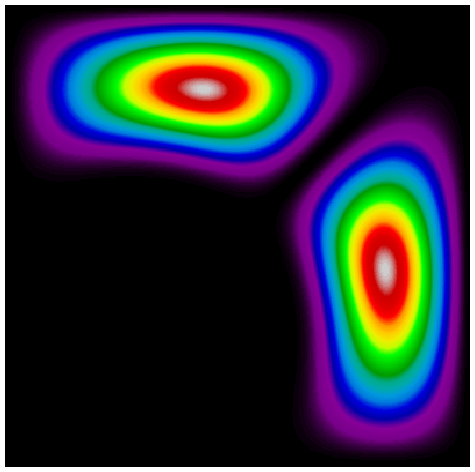

In [9]:
plt.figure(figsize=(6,6))
plt.pcolormesh(X, Y, get_e(1)**2, cmap='nipy_spectral')
plt.axis('off')
plt.show()

# Moving To 3D

The hydrogen atom potential (choosing $\hbar=1$) can be expressed as

$$V(r) = -\frac{e^2}{4 \pi \epsilon_0 r} = -\frac{1}{m a_0 r}$$

and thus 

$$m \Delta x^2 V = -\frac{\Delta x^2}{a_0 r} = -\frac{(\Delta x/a_0)^2}{(r/a_0)}$$

So we'll express $\Delta x$ and $r$ in units of $a_0$

In [10]:
N = 120
X, Y, Z = np.mgrid[-25:25:N*1j, -25:25:N*1j, -25:25:N*1j] # in units of a0, 25 is good
dx = np.diff(X[:,0,0])[0] # in units of a0

Function to get hydrogen wave function potential

In [11]:
def get_potential(x, y, z):
    return - dx**2 / np.sqrt(x**2 + y**2 + z**2 + 1e-10)
V = get_potential(X,Y,Z)

In [12]:
V.shape

(120, 120, 120)

Now that we're in 3D, our matrix should be written as

$$\left[-\frac{1}{2}(D \oplus D \oplus D) + m\Delta x^2 V \right] \psi = \left(m \Delta x^2 E\right) \psi$$

In [13]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sparse.kronsum(sparse.kronsum(D,D), D)
U = sparse.diags(V.reshape(N**3), (0))
H = T+U

In [14]:
H.shape

(1728000, 1728000)

Convert to sparse PyTorch tensor

In [15]:
H = H.tocoo()
H = torch.sparse_coo_tensor(indices=torch.tensor([H.row, H.col]), values=torch.tensor(H.data), size=H.shape).to(device)

Compute eigenvalues/eigenvectors

In [16]:
eigenvalues, eigenvectors = lobpcg(H, k=20, largest=False)

Function to get eigenvector:

In [17]:
def get_e(n):
    return eigenvectors.T[n].reshape((N,N,N)).cpu().numpy()

Compute vertices and faces corresponding to iso-surface of eigenfunction so we can show it off in 3D

In [48]:
verts, faces, _, _ = measure.marching_cubes(get_e(3)**2, 1e-6, spacing=(0.1, 0.1, 0.1))
intensity = np.linalg.norm(verts, axis=1)

In [49]:
fig = go.Figure(data=[go.Mesh3d(x=verts[:, 0], y=verts[:, 1], z=verts[:, 2], 
                                i=faces[:, 0], j=faces[:, 1], k=faces[:, 2],
                                intensity=intensity,
                                colorscale='Agsunset',
                                opacity=0.5)])

fig.update_layout(scene=dict(xaxis=dict(visible=False),
                              yaxis=dict(visible=False),
                              zaxis=dict(visible=False),
                              bgcolor='rgb(0, 0, 0)'),
                  margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Plot the eigenvalue Spectrum:

* The eigenvalues we found are $\mu = m \Delta x^2 E$. First we insert $\hbar$ in to make this dimensionless (no longer use the convention $\hbar=1$)  so that $\mu = m \Delta x^2 E / \hbar^2$. Then, identifying that we made $\Delta$ x in units of $a$, we insert $a$ into the expression so that $\mu = m (a \Delta x)^2 E / \hbar^2$ solving for $E$,

$$E = \frac{\hbar^2}{m \Delta x^2 a^2}$$

In [38]:
hbar = 1.055e-34
a = 5.29e-11
m = 9.11e-31
J_to_eV = 6.242e18 # convert from Joules to eV
conversion = hbar**2 / m / dx**2 / a**2 * J_to_eV 

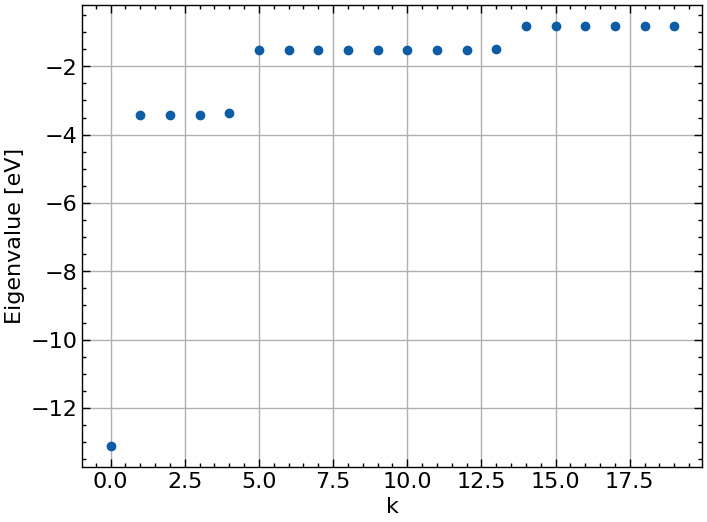

In [39]:
plt.plot(eigenvalues.cpu() * conversion, 'o')
plt.xlabel('k')
plt.ylabel('Eigenvalue [eV]')
plt.grid()

In [40]:
eigenvalues.cpu() * conversion,

(tensor([-13.1011,  -3.4247,  -3.4247,  -3.4247,  -3.3599,  -1.5176,  -1.5176,
          -1.5176,  -1.5155,  -1.5155,  -1.5155,  -1.5148,  -1.5148,  -1.4953,
          -0.8303,  -0.8155,  -0.8154,  -0.8154,  -0.8076,  -0.8075],
        dtype=torch.float64),)